# Modeling

In [1]:
from os import path
from decimal import Decimal

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier, Pool, metrics, cv
from catboost.utils import get_roc_curve
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.decomposition import KernelPCA

plt.style.use('ggplot')
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [2]:
DATA_DIR = path.join(path.pardir, 'data')
PAN_DIR = path.join(DATA_DIR, 'pangenomes')
FIG_DIR = path.join(path.pardir, 'figs')
MODEL_DIR = path.join(path.pardir, 'models')

## Bonferroni Correction

In [3]:
def bonferroni(initial, n_patterns):
    return Decimal(initial / n_patterns)


# Jumlah kmers tiap antibiotik, lihat `count_kmers.txt`
thres_ethambutol = bonferroni(0.05, 1102609188)
thres_isoniazid = bonferroni(0.05, 2539368683)
thres_rifampin = bonferroni(0.05, 1690584957)

thres_ethambutol, thres_isoniazid, thres_rifampin

(Decimal('4.5346982905787288743231720075928616910110324766947087482549250125885009765625E-11'),
 Decimal('1.968993330300120086934525289387178624556096195874488330446183681488037109375E-11'),
 Decimal('2.957556187458729575991541200911429110309569523451500572264194488525390625E-11'))

## 1. Preparasi

In [4]:
def get_clusters(antibiotic):
    GENE_CLUSTERS_PATH = path.join(PAN_DIR, antibiotic, 'pyseer', 'gene_clusters.txt')
    with open(GENE_CLUSTERS_PATH, 'r') as f:
        lines = f.read().splitlines() 
    return lines


def get_traits(antibiotic):
    TRAITS_PATH = path.join(DATA_DIR, f'traits_{antibiotic}.tsv')
    traits = pd.read_csv(TRAITS_PATH, sep='\t')
    traits.columns = ['id', 'resistance']
    return traits



def get_cluster2hash(antibiotic):
    KMERS_HASHES_PATH = path.join(PAN_DIR, antibiotic, 'panfeed1', 'kmers_to_hashes.tsv')
    hashes = pd.read_csv(KMERS_HASHES_PATH, sep='\t')
    return hashes


def get_pyseer(antibiotic):
    PYSEER_PATH = path.join(PAN_DIR, antibiotic, 'pyseer', 'pyseer.tsv')
    pyseer = pd.read_csv(PYSEER_PATH, sep='\t')
    return pyseer



def get_filtered_kmers(antibiotic, threshold):
    kmers = get_cluster2hash(antibiotic)
    kmers = kmers[kmers.cluster.isin(get_clusters(antibiotic))]

    pvals = get_pyseer(antibiotic)[['variant', 'lrt-pvalue']]
    pvals.columns = ['variant', 'pvalue']
    pvals = pvals[pvals.pvalue <= threshold]

    kmers = get_cluster2hash(antibiotic)
    kmers.columns = ['cluster', 'kmer', 'variant']
    kmers = kmers.dropna(subset=['kmer'])
    kmers = kmers[kmers.variant.isin(pvals.variant)]
    return kmers


def get_hashes_patterns(antibiotic):
    PATTERN_PATH = path.join(PAN_DIR, antibiotic, 'panfeed1', 'hashes_to_patterns.tsv')
    return pd.read_csv(PATTERN_PATH, sep='\t')


def get_kmers_matrix(antibiotic, threshold):
    kmers = get_filtered_kmers(antibiotic, threshold)
    patterns = get_hashes_patterns(antibiotic)

    patterns = patterns[patterns.hashed_pattern.isin(kmers.variant)]

    M = patterns.copy()[0:0]

    for _, sample in patterns.iterrows():
        for _, mer in kmers.iterrows():
            if sample['hashed_pattern'] == mer['variant']:
                sample_mer = sample.copy()
                sample_mer['hashed_pattern'] = mer['kmer']
                M = pd.concat([M, sample_mer.to_frame().T])

    M = M.rename(columns={'hashed_pattern': 'kmer'})
    M = M.set_index('kmer')
    # Sedikit cek
    assert all(patterns.iloc[0, 1:] == M.iloc[0, :])
    
    M = M.T.reset_index().rename(columns={'index': 'id'})
    M.index.name = None
    M.rename_axis(None, axis=1, inplace=True)
    return M


def get_data(antibiotic, threshold):
    X = get_kmers_matrix(antibiotic, threshold)
    y = get_traits(antibiotic)
    return pd.merge(y, X, how='inner', on='id')

In [5]:
antibiotic = 'ethambutol'
threshold = thres_ethambutol

get_filtered_kmers(antibiotic, threshold)

,cluster,kmer,variant
102230,embB,AATTCGTCGGACGACGGCTACATCCTGGGCA,RBRdoxIbsCo9k//3cVm+wA==
102231,embB,ATGCCCAGGATGTAGCCGTCGTCCGACGAAT,RBRdoxIbsCo9k//3cVm+wA==
102232,embB,CATGCCCAGGATGTAGCCGTCGTCCGACGAA,tYbHr5aU1LE2/IQoNJNLUw==
102233,embB,CCATGCCCAGGATGTAGCCGTCGTCCGACGA,tYbHr5aU1LE2/IQoNJNLUw==
102234,embB,CGTCGGACGACGGCTACATCCTGGGCATGGC,tYbHr5aU1LE2/IQoNJNLUw==
...,...,...,...
1320799,group_3440,CGAGGCTGCCTACTACGCTCAACGCCAGAGA,pkgq68ekdhSm+0Uvu4wMDA==
1320800,group_3440,CTCTGGCGTTGAGCGTAGTAGGCAGCCTCGA,pkgq68ekdhSm+0Uvu4wMDA==
1320801,group_3440,CTCGAGGCTGCCTACTACGCTCAACGCCAGA,pkgq68ekdhSm+0Uvu4wMDA==
1320802,group_3440,ACTCGAGGCTGCCTACTACGCTCAACGCCAG,pkgq68ekdhSm+0Uvu4wMDA==


In [6]:
get_data(antibiotic, threshold)

,id,resistance,AATTCGTCGGACGACGGCTACATCCTGGGCA,ATGCCCAGGATGTAGCCGTCGTCCGACGAAT,CATGCCCAGGATGTAGCCGTCGTCCGACGAA,CCATGCCCAGGATGTAGCCGTCGTCCGACGA,CGTCGGACGACGGCTACATCCTGGGCATGGC,GGCCATGCCCAGGATGTAGCCGTCGTCCGAC,GGGCCATGCCCAGGATGTAGCCGTCGTCCGA,CGGACGACGGCTACATCCTGGGCATGGCCCG,...,CTGCCTACTACGCTCAACGCCAGAGACCAGC,CTGGTCTCTGGCGTTGAGCGTAGTAGGCAGC,GGCTGCCTACTACGCTCAACGCCAGAGACCA,AGGCTGCCTACTACGCTCAACGCCAGAGACC,GAGGCTGCCTACTACGCTCAACGCCAGAGAC,CGAGGCTGCCTACTACGCTCAACGCCAGAGA,CTCTGGCGTTGAGCGTAGTAGGCAGCCTCGA,CTCGAGGCTGCCTACTACGCTCAACGCCAGA,ACTCGAGGCTGCCTACTACGCTCAACGCCAG,AACTCGAGGCTGCCTACTACGCTCAACGCCA
0,1438835.3.PATRIC,0,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,1438837.3.PATRIC,0,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,1438842.3.PATRIC,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,83331.31.PATRIC,0,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
4,1448833.3.PATRIC,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,1438867.3.PATRIC,0,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
245,652616.4.PATRIC,0,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
246,1773.199.PATRIC,0,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
247,1773.200.PATRIC,0,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0


## 2. Split Train/Test

In [7]:
def split_train_test(data):
    X = data.iloc[:, 2:].to_numpy()
    y = data.iloc[:, 1].to_numpy()
    return train_test_split(X, y, stratify=y, test_size=0.2, random_state=1)

In [8]:
data = get_data(antibiotic, threshold)
X_train, X_test, y_train, y_test = split_train_test(data)

for arr in [X_train, X_test, y_train, y_test]:
    print(arr.shape)

(199, 2817)
(50, 2817)
(199,)
(50,)


In [9]:
def report_split(data, antibiotic):
    X_id = data.iloc[:, 0]
    y_id = data.iloc[:, 1]
    X_id_train, X_id_test, y_id_train, y_id_test = train_test_split(X_id, y_id, stratify=y_id, test_size=0.2, random_state=1)

    X_id_train.to_csv(path.join(path.curdir, f"id_{antibiotic}_train.csv"), index=None)
    X_id_test.to_csv(path.join(path.curdir, f"id_{antibiotic}_test.csv"), index=None)
    
    
emb_data = get_data('ethambutol', thres_ethambutol)
report_split(emb_data, 'ethambutol')

inh_data = get_data('isoniazid', thres_isoniazid)
report_split(inh_data, 'isoniazid')

rif_data = get_data('rifampin', thres_rifampin)
report_split(rif_data, 'rifampin')

## 3. CatBoost

### 3.1 Cross-validation (tanpa _tuning_)

In [10]:
def cv_train(X_train, y_train, antibiotic):
    cat_features = list(range(0, X_train.shape[1]))

    clf = CatBoostClassifier(
        custom_loss=[metrics.AUC()],
        logging_level='Silent',
        random_state=1,
    )

    cv_params = clf.get_params()
    cv_params.update({ 'loss_function': metrics.Logloss()})

    cv_data = cv(
        Pool(
            X_train, 
            y_train, 
            cat_features=cat_features
        ),
        cv_params,
        plot=True
    )

    print('{} = Best validation AUC score: {:.2f}±{:.2f} on step {}'.format(
        antibiotic.title(),
        np.max(cv_data['test-AUC-mean']),
        cv_data['test-AUC-std'][np.argmax(cv_data['test-AUC-mean'])],
        np.argmax(cv_data['test-AUC-mean'])
    ))

In [11]:
cv_train(X_train, y_train, antibiotic)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Ethambutol = Best validation AUC score: 0.89±0.04 on step 8


### 3.2 Training & Test

In [12]:
def train(X_train, y_train):
    cat_features = list(range(0, X_train.shape[1]))
    clf = CatBoostClassifier(
        custom_loss=[metrics.AUC()],
        logging_level='Silent',
        random_state=1,
    )
    return clf.fit(
        X_train, 
        y_train, 
        cat_features=cat_features
    )


def test_auc(clf, X_test, y_test, antibiotic):
    y_pred = clf.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_pred)
    print(f'{antibiotic.title()}: Skor AUC = %.3f' % auc)
    return auc

In [13]:
clf = train(X_train, y_train)
auc = test_auc(clf, X_test, y_test, antibiotic)

Ethambutol: Skor AUC = 0.917


## 4. Pipeline

### 4.1 Ethambutol

In [14]:
emb = 'ethambutol'

# Menentukan p-value
# https://journals.plos.org/plosbiology/article?id=10.1371/journal.pbio.3001755
emb_data = get_data(emb, thres_ethambutol)

emb_X_train, emb_X_test, emb_y_train, emb_y_test = split_train_test(emb_data)

cv_train(emb_X_train, emb_y_train, emb)
emb_clf = train(emb_X_train, emb_y_train)

# Simpan model
emb_clf.save_model(path.join(MODEL_DIR, f'{emb}_clf.cbm'), format='cbm')

# Simpan matriks header untuk app
emb_head = emb_data.iloc[0:0, 2:]
emb_head.to_csv(path.join(MODEL_DIR, f'{emb}_matrix_head.tsv'), sep='\t', index=False)
emb_head

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Ethambutol = Best validation AUC score: 0.89±0.04 on step 8


,AATTCGTCGGACGACGGCTACATCCTGGGCA,ATGCCCAGGATGTAGCCGTCGTCCGACGAAT,CATGCCCAGGATGTAGCCGTCGTCCGACGAA,CCATGCCCAGGATGTAGCCGTCGTCCGACGA,CGTCGGACGACGGCTACATCCTGGGCATGGC,GGCCATGCCCAGGATGTAGCCGTCGTCCGAC,GGGCCATGCCCAGGATGTAGCCGTCGTCCGA,CGGACGACGGCTACATCCTGGGCATGGCCCG,GGACGACGGCTACATCCTGGGCATGGCCCGA,CTCGGGCCATGCCCAGGATGTAGCCGTCGTC,...,CTGCCTACTACGCTCAACGCCAGAGACCAGC,CTGGTCTCTGGCGTTGAGCGTAGTAGGCAGC,GGCTGCCTACTACGCTCAACGCCAGAGACCA,AGGCTGCCTACTACGCTCAACGCCAGAGACC,GAGGCTGCCTACTACGCTCAACGCCAGAGAC,CGAGGCTGCCTACTACGCTCAACGCCAGAGA,CTCTGGCGTTGAGCGTAGTAGGCAGCCTCGA,CTCGAGGCTGCCTACTACGCTCAACGCCAGA,ACTCGAGGCTGCCTACTACGCTCAACGCCAG,AACTCGAGGCTGCCTACTACGCTCAACGCCA


### 4.2 Isoniazid

In [15]:
inh = 'isoniazid'

# Menentukan p-value
# https://journals.plos.org/plosbiology/article?id=10.1371/journal.pbio.3001755
inh_data = get_data(inh, thres_isoniazid)

inh_X_train, inh_X_test, inh_y_train, inh_y_test = split_train_test(inh_data)

cv_train(inh_X_train, inh_y_train, inh)
inh_clf = train(inh_X_train, inh_y_train)

# Simpan model
inh_clf.save_model(path.join(MODEL_DIR, f'{inh}_clf.cbm'), format='cbm')

# Simpan matriks header untuk app
inh_head = inh_data.iloc[0:0, 2:]
inh_head.to_csv(path.join(MODEL_DIR, f'{inh}_matrix_head.tsv'), sep='\t', index=False)
inh_head

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Isoniazid = Best validation AUC score: 0.96±0.02 on step 9


,GACAGTCGGCGCTTGTGGGTCAACCCCGACA,CGACAGTCGGCGCTTGTGGGTCAACCCCGAC,CCGACAGTCGGCGCTTGTGGGTCAACCCCGA,CGGGGTTGACCCACAAGCGCCGACTGTCGGC,CGCCGACAGTCGGCGCTTGTGGGTCAACCCC,GCGCCGACAGTCGGCGCTTGTGGGTCAACCC,AGCGCCGACAGTCGGCGCTTGTGGGTCAACC,CAGCGCCGACAGTCGGCGCTTGTGGGTCAAC,CCAGCGCCGACAGTCGGCGCTTGTGGGTCAA,CCCAGCGCCGACAGTCGGCGCTTGTGGGTCA,...,CTGTCACCCCACTGTCGGCTGACCATCCGAA,GCTGTCACCCCACTGTCGGCTGACCATCCGA,CGGATGGTCAGCCGACAGTGGGGTGACAGCC,CGGCTGTCACCCCACTGTCGGCTGACCATCC,GATGGTCAGCCGACAGTGGGGTGACAGCCGA,ATGGTCAGCCGACAGTGGGGTGACAGCCGAC,TGGTCAGCCGACAGTGGGGTGACAGCCGACA,ATGTCGGCTGTCACCCCACTGTCGGCTGACC,GATGTCGGCTGTCACCCCACTGTCGGCTGAC,TCAGCCGACAGTGGGGTGACAGCCGACATCA


### 4.3 Rifampin

In [16]:
rif = 'rifampin'

# Menentukan p-value
# https://journals.plos.org/plosbiology/article?id=10.1371/journal.pbio.3001755
rif_data = get_data(rif, thres_rifampin)

rif_X_train, rif_X_test, rif_y_train, rif_y_test = split_train_test(rif_data)

cv_train(rif_X_train, rif_y_train, rif)
rif_clf = train(rif_X_train, rif_y_train)

# Simpan model
rif_clf.save_model(path.join(MODEL_DIR, f'{rif}_clf.cbm'), format='cbm')

# Simpan matriks header untuk app
rif_head = rif_data.iloc[0:0, 2:]
rif_head.to_csv(path.join(MODEL_DIR, f'{rif}_matrix_head.tsv'), sep='\t', index=False)
rif_head

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Rifampin = Best validation AUC score: 0.95±0.02 on step 165


,GACAGTCGGCGCTTGTGGGTCAACCCCGACA,CGACAGTCGGCGCTTGTGGGTCAACCCCGAC,CCGACAGTCGGCGCTTGTGGGTCAACCCCGA,CGGGGTTGACCCACAAGCGCCGACTGTCGGC,CGCCGACAGTCGGCGCTTGTGGGTCAACCCC,GCGCCGACAGTCGGCGCTTGTGGGTCAACCC,AGCGCCGACAGTCGGCGCTTGTGGGTCAACC,CAGCGCCGACAGTCGGCGCTTGTGGGTCAAC,CCAGCGCCGACAGTCGGCGCTTGTGGGTCAA,CCCAGCGCCGACAGTCGGCGCTTGTGGGTCA,...,CACCCCGAGAAGCTGCTACGCCACAACGACG,ACCCCGAGAAGCTGCTACGCCACAACGACGA,CCCCGAGAAGCTGCTACGCCACAACGACGAG,CCCGAGAAGCTGCTACGCCACAACGACGAGG,CCGAGAAGCTGCTACGCCACAACGACGAGGA,ATTGAACCGCCCCGGCATGTCCGGAGACTCC,CTGTGAACCGCCCCGGTGAGTCCGGAGACTC,AGAGTCTCCGGACTCACCGGGGCGGTTCAGA,GAGAGTCTCCGGACTCACCGGGGCGGTTCAA,AGAGTCTCCGGACTCACCGGGGCGGTTCAAT


### 4.4 Evaluasi total

Ethambutol: Skor AUC = 0.917
Isoniazid: Skor AUC = 0.954
Rifampin: Skor AUC = 0.932


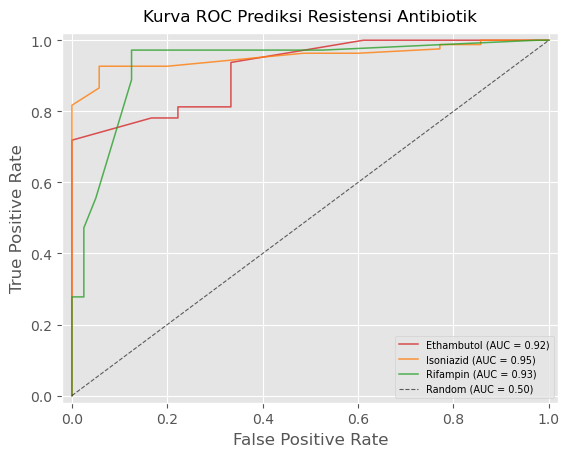

In [17]:
def plot_roc(clf, X_test, y_test, antibiotic, color):
    y_pred = clf.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    
    plt.plot(
        fpr, tpr, 
        color=color, 
        linestyle='solid', 
        lw=1.1,
        alpha=0.8,
        label=f'{antibiotic.title()} (AUC = {test_auc(clf, X_test, y_test, antibiotic):.2f})'
    )


plot_roc(emb_clf, emb_X_test, emb_y_test, emb, 'tab:red')
plot_roc(inh_clf, inh_X_test, inh_y_test, inh, 'tab:orange')
plot_roc(rif_clf, rif_X_test, rif_y_test, rif, 'tab:green')

plt.plot(
    [0, 1], [0, 1], 
    color='black', 
    lw=0.8, 
    linestyle='dashed', 
    alpha=0.6, 
    label='Random (AUC = 0.50)'
)

plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('Kurva ROC Prediksi Resistensi Antibiotik', y=1.01, size='large')
plt.legend(loc='lower right', prop={'size': 7})

plt.savefig(path.join(FIG_DIR, 'roc.png'), format='png', dpi=600, bbox_inches='tight')
plt.show()